<a href="https://colab.research.google.com/github/zhukuixi/Udacity_DataScientistNanoDegree/blob/main/H%26M%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',50)

In [4]:
articles = pd.read_csv('/content/drive/MyDrive/H&M_data/data/articles.csv')
customers = pd.read_csv('/content/drive/MyDrive/H&M_data/data/customers.csv')
transactions = pd.read_csv('/content/drive/MyDrive/H&M_data/data/transactions_train.csv').sample(100000).reset_index(drop=True)

# Data Visualization


### [Article]:Word Count Barplot Visualization

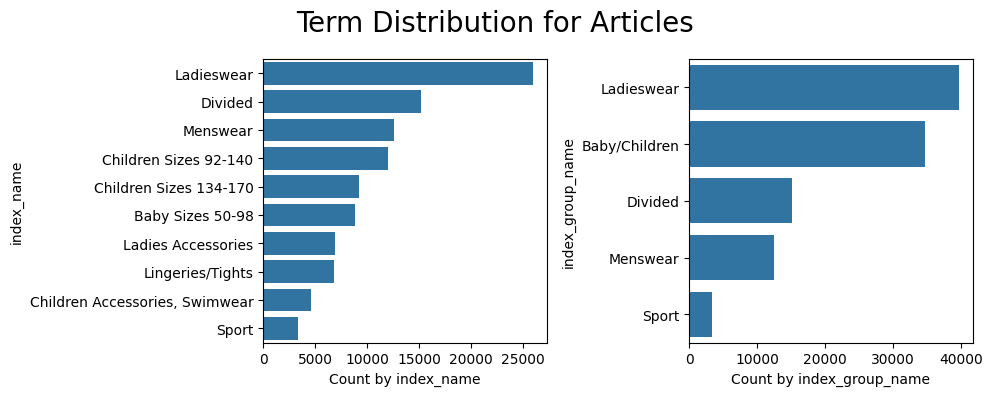

In [5]:
target_col = ['index_name','index_group_name']
fig,ax = plt.subplots(1,len(target_col),figsize=(10,4))
fig.suptitle('Term Distribution for Articles',size=20)
for i in range(len(target_col)):
  feature = target_col[i]
  temp = articles[feature].value_counts().reset_index()
  temp.columns=[feature,'frequency']
  sns.barplot(data=temp,x='frequency',y=feature,ax=ax[i])
  ax[i].set_ylabel(feature)
  ax[i].set_xlabel(f'Count by {feature}')
plt.tight_layout()
plt.show()

In [6]:
plt.figure(1,figsize=(10,10))

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

## [Customer]: Customer Age Distribution

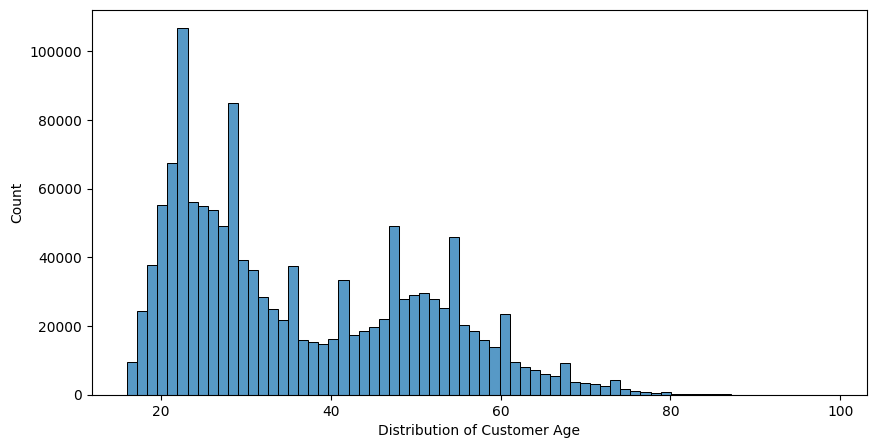

In [7]:
fig,ax = plt.subplots(figsize=(10,5))
sns.histplot(customers['age'],bins=70,ax=ax)
ax.set_xlabel('Distribution of Customer Age')
plt.show()

## [Customer]: Customer Member Status

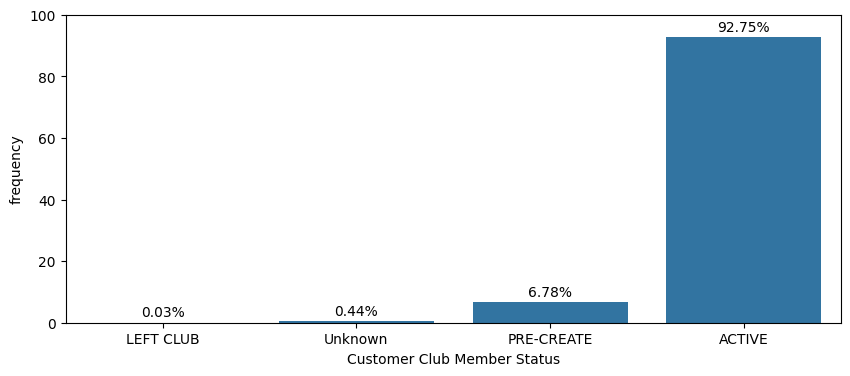

In [8]:
temp = customers['club_member_status'].value_counts(dropna=False).reset_index()
temp.columns=['club member status','frequency']
temp.sort_values('frequency',inplace=True)
temp['club member status'].replace(np.nan,'Unknown',inplace=True)
temp['frequency'] = (100*temp['frequency']/temp['frequency'].sum()).round(2)
fig,ax = plt.subplots(figsize=(10,4))
sns.barplot(data=temp,x='club member status',y='frequency',ax=ax)
ax.set_xlabel('Customer Club Member Status')
ax.set_ylim(0,100)

# Add numbers on top of each bar
for i, v in enumerate(temp['frequency']):
    plt.text(i, v + 1, f'{v}%', ha='center', va='bottom')
plt.show()



## [Transactions]: Transaction Price Ditribution in Different Sale Channel

In [9]:
d1 = transactions.query('sales_channel_id==1')['price']
d2 = transactions.query('sales_channel_id==2')['price']
d3 = transactions['price']

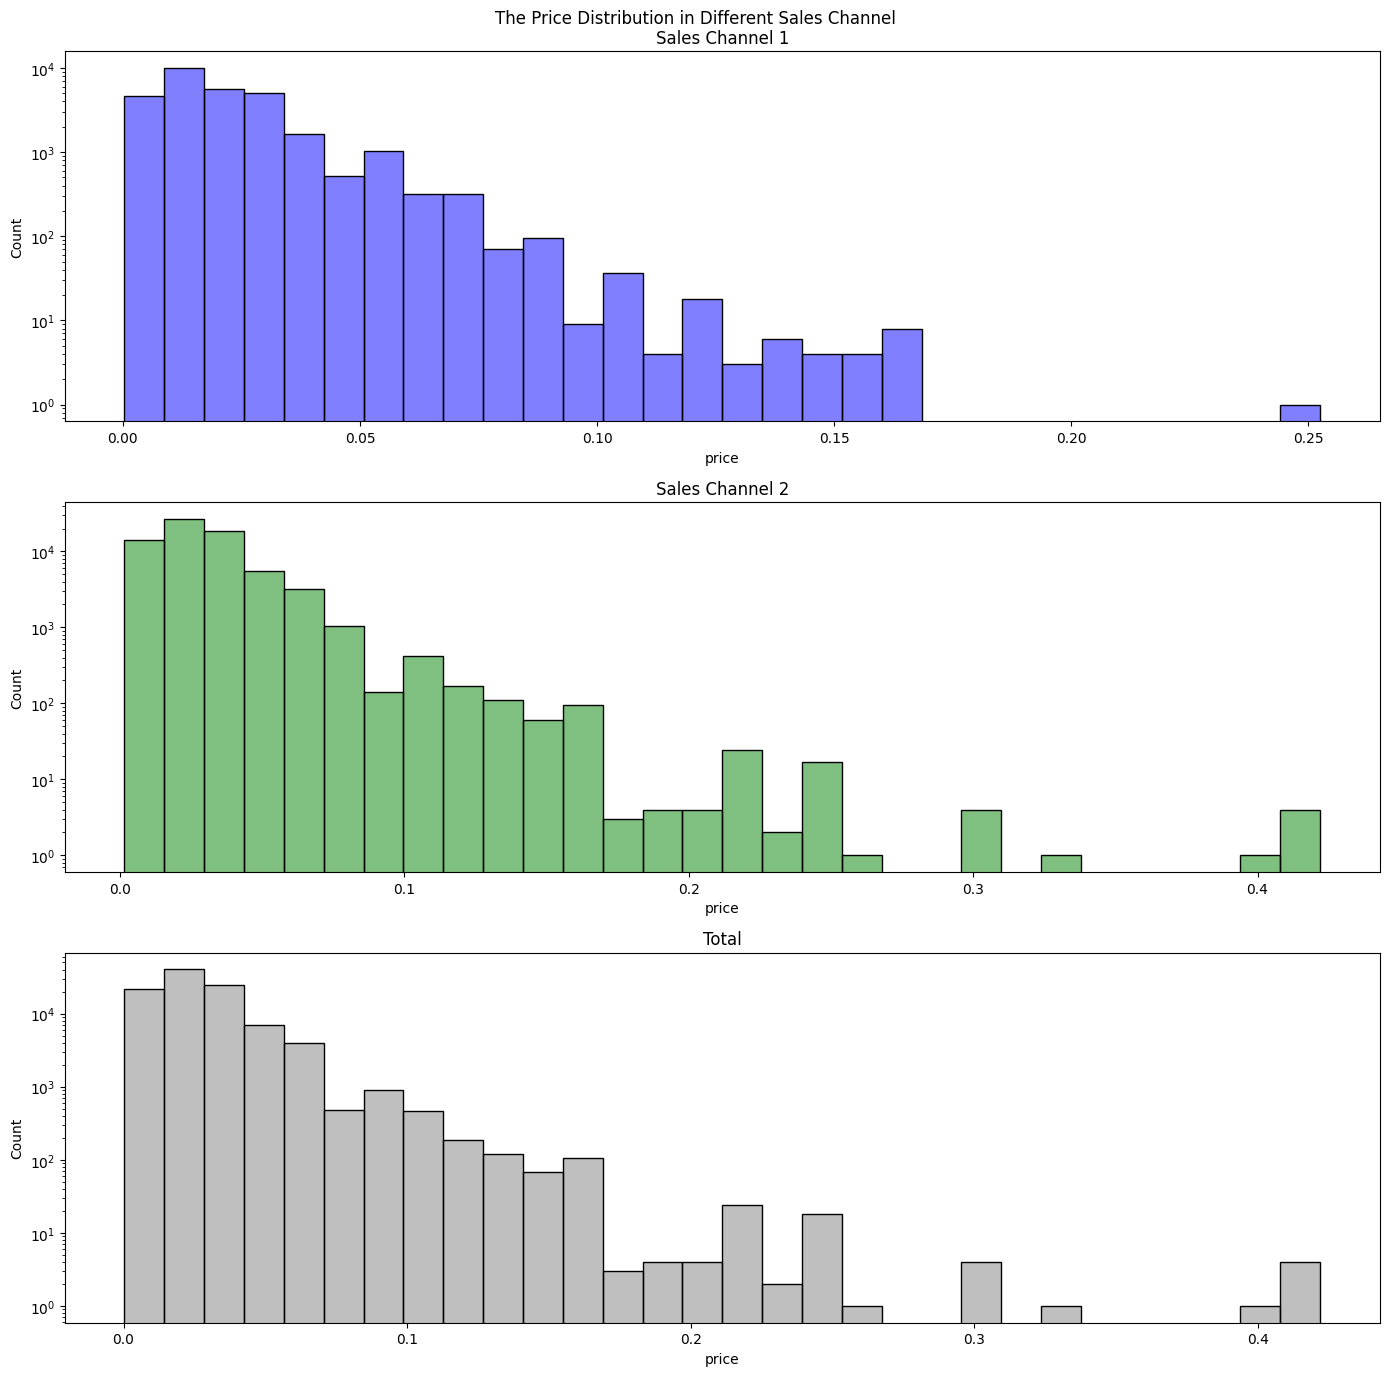

In [10]:
fig,ax = plt.subplots(3,1,figsize=(14,14))
# Sales Channel 1
fig.suptitle('The Price Distribution in Different Sales Channel')
sns.histplot(d1,ax=ax[0],bins=30,alpha=0.5,color='blue')
ax[0].set_title('Sales Channel 1')
ax[0].set_yscale('log')
sns.histplot(d2,ax=ax[1],bins=30,alpha=0.5,color='green')
ax[1].set_title('Sales Channel 2')
ax[1].set_yscale('log')
sns.histplot(d3,ax=ax[2],bins=30,alpha=0.5,color='grey')
ax[2].set_title('Total')
ax[2].set_yscale('log')
plt.tight_layout()
plt.show()

## [Transaction + Article]: Price Trends of Various Products Over Time




In [11]:
article_for_merge = transactions[['customer_id','article_id','price','t_dat']].merge(articles[['article_id','prod_name','product_type_name','product_group_name','index_name']],on='article_id',how='left')
article_for_merge['t_dat'] = pd.to_datetime(article_for_merge['t_dat'])

In [12]:
product_list = ['Shoes','Garment Full body','Bags','Garment Lower body','Underwear']
colors = ['cadetblue','orange','mediumspringgreen','tomato','lightseagreen']

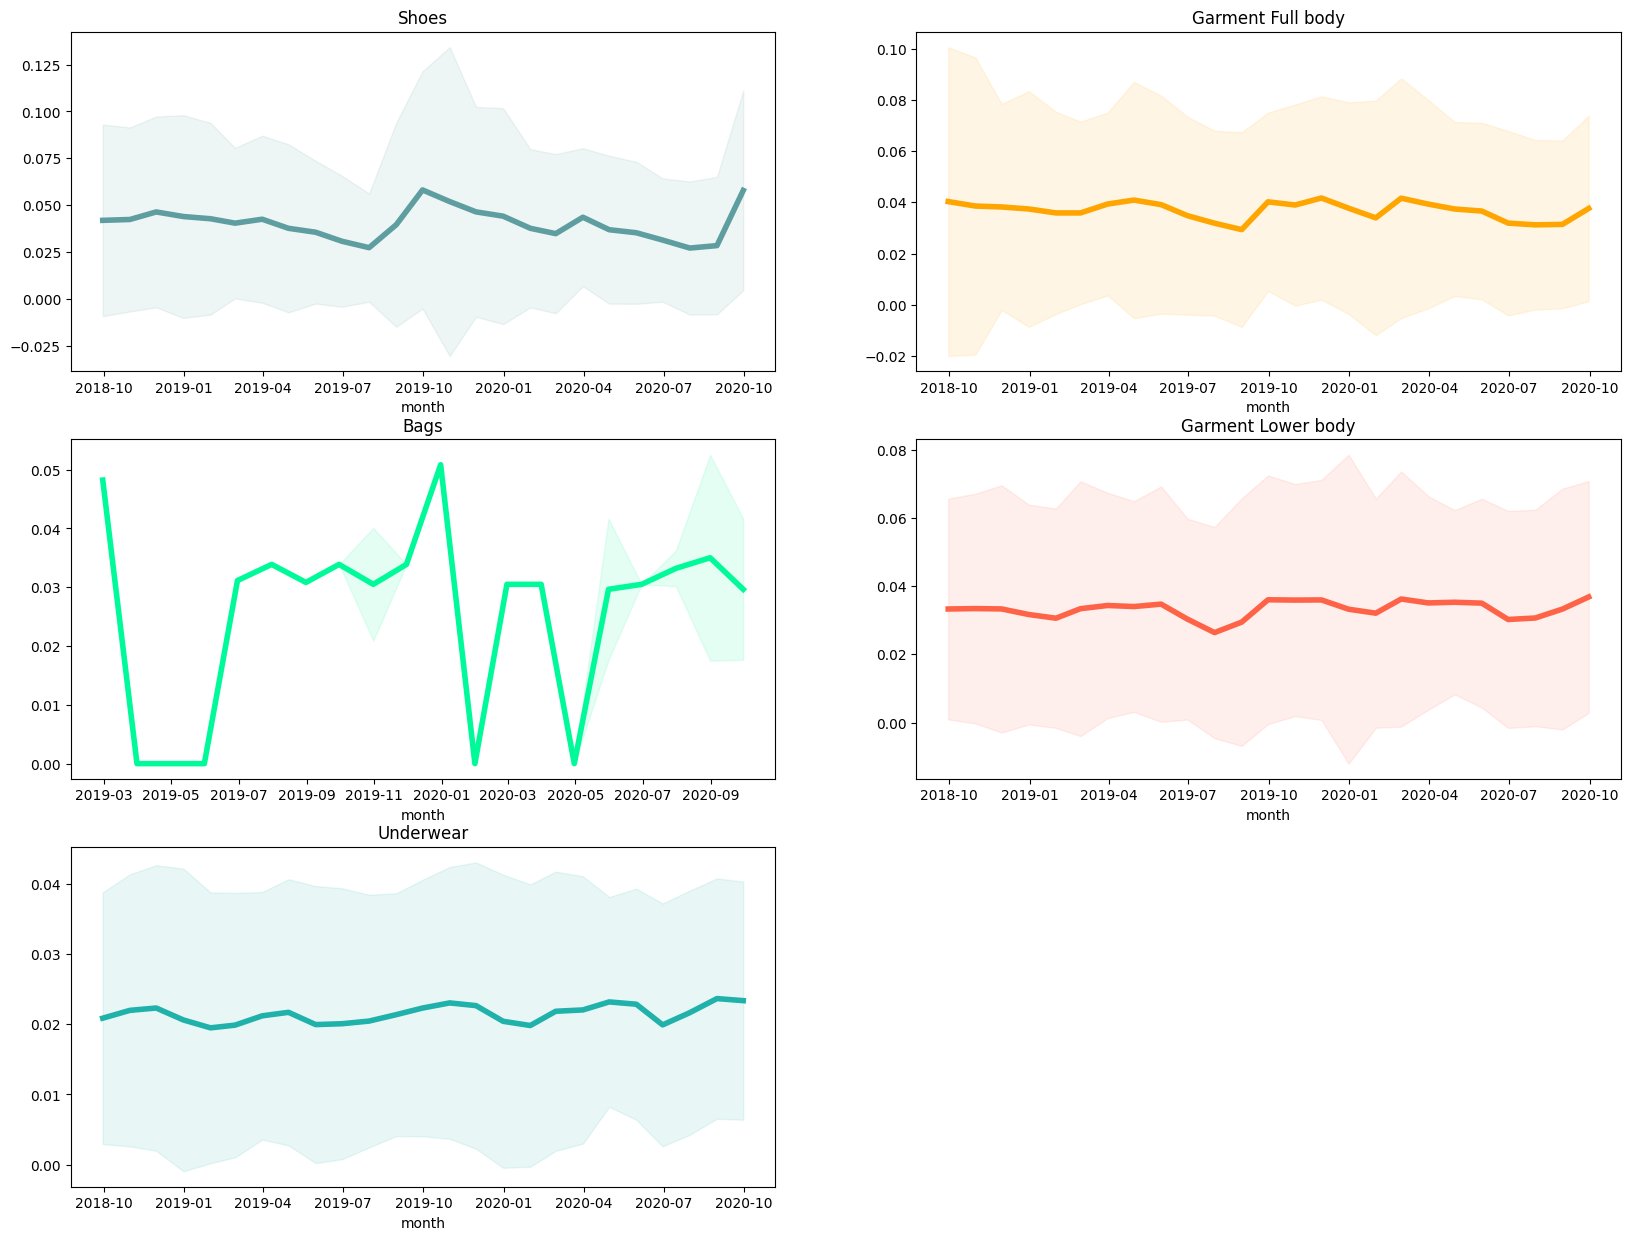

In [13]:
k = 0
f, ax = plt.subplots(3,2,figsize=(20,15))
for i in range(3):
  for j in range(2):
    try:
      product = product_list[k]
      article_for_merge_product = article_for_merge.query('product_group_name==@product')
      result = article_for_merge_product[['t_dat','price']].groupby(pd.Grouper(key='t_dat',freq='M')).agg( \
               mean = ('price','mean'),
                std = ('price','std')
      ).fillna(0)
      ax[i,j].plot(result['mean'],linewidth=4,color=colors[k])
      ax[i,j].fill_between(x=result.index,y1=result['mean']-2*result['std'],y2=result['mean']+2*result['std'],color=colors[k],alpha=0.1)
      ax[i,j].set_title(f'{product}')
      ax[i,j].set_xlabel('month')
      k += 1
    except IndexError:
      ax[i,j].set_visible(False)
plt.show()

##[Transaction]: Daily Transaction Over Time


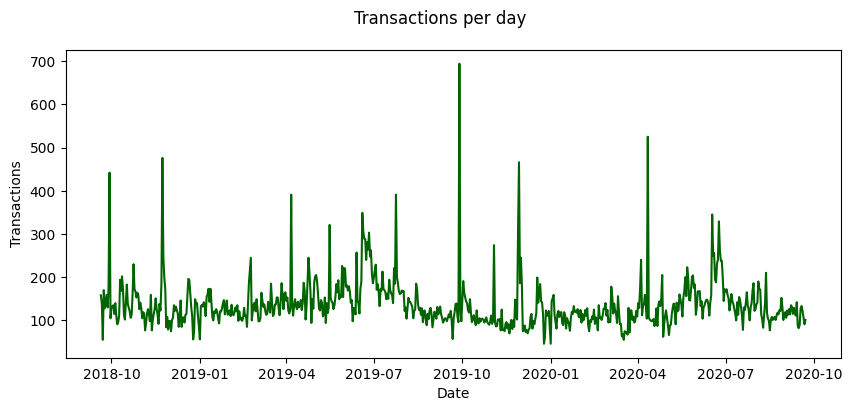

In [14]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
df = transactions.groupby('t_dat')['article_id'].count().reset_index(name='transaction count')
ax.plot(df['t_dat'],df['transaction count'],color='Darkgreen')
ax.set_xlabel('Date')
ax.set_ylabel('Transactions')
plt.suptitle('Transactions per day')
plt.show()

##[Transaction]: Daily Transaction of Differnet Sales Channel Over Time


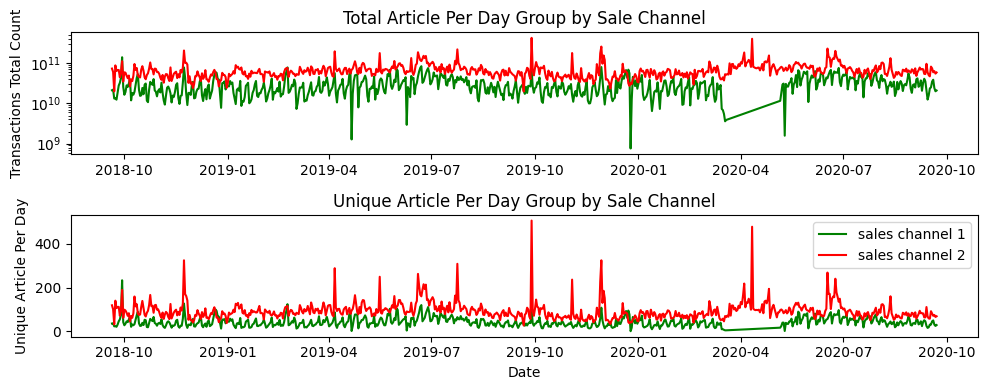

In [15]:
fig, ax = plt.subplots(2,1,figsize=(10,4))
df = transactions.groupby(['t_dat','sales_channel_id']).agg(
                                transaction_count = ('article_id','sum'),
                                transaction_uniqueCount = ('article_id',lambda x:x.nunique()),
                               ).reset_index()

ax[0].plot(df.query('sales_channel_id==1')['t_dat'],df.query('sales_channel_id==1')['transaction_count'],color='green',label='sales channel:1 total sale')
ax[0].plot(df.query('sales_channel_id==2')['t_dat'],df.query('sales_channel_id==2')['transaction_count'],color='red',label='sales channel:2 total sale')
ax[0].set_ylabel('Transactions Total Count')
ax[0].set_title('Total Article Per Day Group by Sale Channel')
ax[0].set_yscale('log')

ax[1].plot(df.query('sales_channel_id==1')['t_dat'],df.query('sales_channel_id==1')['transaction_uniqueCount'],color='green',label='sales channel 1')
ax[1].plot(df.query('sales_channel_id==2')['t_dat'],df.query('sales_channel_id==2')['transaction_uniqueCount'],color='red',label='sales channel 2')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Unique Article Per Day')
ax[1].set_title('Unique Article Per Day Group by Sale Channel')

plt.legend()
plt.tight_layout()
plt.show()

In [16]:
transactions.sales_channel_id.value_counts()

2    70480
1    29520
Name: sales_channel_id, dtype: int64

# Feature Engineering

In [17]:
df = transactions.merge(articles,on='article_id',how='left').merge(customers,on='customer_id',how='left')

## Feature Engineering for Continuous Feature

In [18]:
def num_add(df,f1,f2):
  # add
  df[f'{f1}_add_{f2}'] = df[f1] + df[f2]
  return df

def num_mul(df,f1,f2):
  # mul
  df[f'{f1}_mul_{f2}'] = df[f1] * df[f2]
  return df

def num_div(df,f1,f2):
  # div
  # add a smoothing term
  df[f'{f1}_div_{f2}'] = df[f1] / (df[f2] + df[f2].mean())
  return df

def num_log(df,f):
  # add
  df[f'log_{f}'] = np.log(df[f]+1)
  return df

def num_bin(df,f,num_bins=10,bin_type='cut'):
  # bin
  if bin_type=='cut':
    df[f'{f}_bin_{num_bins}'] = pd.cut(df[f],num_bins)
  elif bin_type=='qcut':
    df[f'{f}_bin_{num_bins}'] = pd.qcut(df[f],num_bins)
  return df


In [19]:
num_bin(df,'age',10,bin_type='qcut')
print(df[['age','age_bin_10']].head())
df.groupby('age_bin_10')['age'].count().head()


    age      age_bin_10
0  35.0    (31.0, 36.0]
1  29.0    (26.0, 29.0]
2  20.0  (15.999, 22.0]
3  68.0    (55.0, 96.0]
4  41.0    (36.0, 44.0]


age_bin_10
(15.999, 22.0]    11671
(22.0, 24.0]       8821
(24.0, 26.0]      10060
(26.0, 29.0]      12844
(29.0, 31.0]       7028
Name: age, dtype: int64

## Feature Engineering for Discrete Feature

In [26]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_enc(df,f):
  # one-hot encoding
  enc = OneHotEncoder()
  transformed_result = enc.fit_transform(df[f].values.reshape(-1,1)).toarray()
  category_cnt = len(enc.categories_[0])
  df[[f'{f}_onehot_{i}' for i in range(category_cnt)]] = transformed_result
  return df

def label_enc(df,f):
  # count encoding
  unique_feature = df[f].unique()
  mapper = dict(zip(unique_feature,range(len(unique_feature))))
  df[f'{f}_label'] = df[f].map(mapper)
  return df

def count_enc(df,f):
  # count encoding
  temp = df[f].value_counts().reset_index(name='cnt')
  mapper = dict(zip(temp.iloc[:,0],temp.iloc[:,1]))
  df[f'{f}_count'] = df[f].map(mapper)
  return df

def cross_enc(df,f1,f2):
  # cross end
  if 'f{f1}_count' not in df.columns:
    df = count_enc(df,f1)
  if 'f{f2}_count' not in df.columns:
    df = count_enc(df,f2)
  df[f'{f1}_{f2}'] = df[f1].astype('str')+'_'+df[f2].astype('str')
  df = count_enc(df,f'{f1}_{f2}')
  df[f'{f1}_{f2}_count_div_{f1}_count'] = df[f'{f1}_{f2}_count'] / (df[f'{f1}_count']+df[f'{f1}_count'].mean())
  df[f'{f1}_{f2}_count_div_{f2}_count'] = df[f'{f1}_{f2}_count'] / (df[f'{f2}_count']+df[f'{f2}_count'].mean())
  df.drop(f'{f1}_{f2}',axis=1,inplace=True)
  return df

def group_stat(df,cat_fea,num_fea):
  # key is category feature
  # value is numeric feature
  for stat in ['min','max','mean','median','std','skew']:
    df[f'{cat_fea}_{num_fea}_groupby_{stat}'] = df.groupby(cat_fea)[num_fea].transform(stat)
  return df



In [23]:
f = 'perceived_colour_value_name'
count_enc(df,f)
label_enc(df,f)
print(df[[f,f'{f}_count']].head())
print(df[[f,f'{f}_label']].head())


  perceived_colour_value_name  perceived_colour_value_name_count
0                        Dark                              49003
1                Medium Dusty                              11886
2                        Dark                              49003
3                        Dark                              49003
4                        Dark                              49003
  perceived_colour_value_name  perceived_colour_value_name_label
0                        Dark                                  0
1                Medium Dusty                                  1
2                        Dark                                  0
3                        Dark                                  0
4                        Dark                                  0


In [30]:
df = cross_enc(df,'age','product_group_name')
f1 = 'age'
f2 = 'product_group_name'
df[[f1,f2,f'{f1}_{f2}_count_div_{f1}_count',f'{f1}_{f2}_count_div_{f2}_count']].head()

,age,product_group_name,age_product_group_name_count_div_age_count,age_product_group_name_count_div_product_group_name_count
0,35.0,Garment Lower body,0.082102,0.008156
1,29.0,Garment Upper body,0.228737,0.024493
2,20.0,Garment Lower body,0.095949,0.011233
3,68.0,Garment Upper body,0.034258,0.001651
4,41.0,Garment Upper body,0.121122,0.007794


In [40]:
df = group_stat(df,'age','price')
cat_fea = 'age'
num_fea = 'price'
df.loc[:,df.columns.str.startswith(f'{cat_fea}_{num_fea}')].head()

,age_price_groupby_min,age_price_groupby_max,age_price_groupby_mean,age_price_groupby_median,age_price_groupby_std,age_price_groupby_skew
0,0.000847,0.252525,0.027765,0.024390,0.020088,3.262193
1,0.000322,0.218644,0.027932,0.025407,0.018549,2.251437
2,0.000847,0.135576,0.024317,0.022017,0.014922,1.648937
3,0.001441,0.159407,0.032532,0.025407,0.023505,2.525832
4,0.001678,0.167797,0.027312,0.024763,0.018887,2.751270
